SA0-LDA

 1.预处理

In [42]:
import os
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [43]:
output_path = 'D:/llda/lda/result'
file_path = 'D:/llda/lda/data'
os.chdir(file_path)
data=pd.read_excel("2022l.xlsx")#content type
os.chdir(output_path)
stop_file = "D:/llda/lda/stop_dic/stopwords.txt"

In [44]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def english_word_cut(mytext):
    stop_list = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    word_list = []
    tokens = word_tokenize(mytext)
    
    for word in tokens:
        word = re.sub(r'[^A-Za-z]', '', word)
        word = word.lower()
        
        if word not in stop_list and len(word) >= 2:
            word = lemmatizer.lemmatize(word)
            word_list.append(word)
    
    return " ".join(word_list)

In [45]:
data["content_cutted"] = data.content.apply(english_word_cut)

2.LDA分析

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [47]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [48]:
n_features = 1000 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [49]:
n_topics = 12
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
                                 doc_topic_prior=0.1,
                                topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.1, learning_offset=50, max_iter=50,
                          n_components=12, random_state=0,
                          topic_word_prior=0.01)

2.1输出每个主题对应词语 

In [50]:
n_top_words = 15
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
circuit device integrated include interface electronic control power apparatus output protection fixing chip unit comprise
Topic #1:
processing signal power device electronic method wireless chip unit connected control conversion include comprise data
Topic #2:
protection use fixing chip method electronic device unit connected comprise wireless fet frequency data equipment
Topic #3:
circuit comprise integrated conversion signal interface control method receive structure second power connected frequency data
Topic #4:
equipment method device information electronic comprise connected control conversion data integrated circuit fet fixing frequency
Topic #5:
method control module frequency structure electronic wireless fixing fet equipment data device information conversion connected
Topic #6:
stacked nanosheet stack fet left connected wireless electronic frequency fixing equipment data device information conversion
Topic #7:
structure pad chip output integrated second frequency 

2.2输出每篇文章对应主题 

In [51]:
import numpy as np

In [52]:
topics=lda.transform(tf)

In [53]:
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_excel("data_topic2022.xlsx",index=False)

2.3可视化 

In [54]:
import pyLDAvis
import pyLDAvis.lda_model

In [55]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)

2.4困惑度 

In [28]:
import matplotlib.pyplot as plt

In [46]:
plexs = []
scores = []
n_max_topics = 15
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14


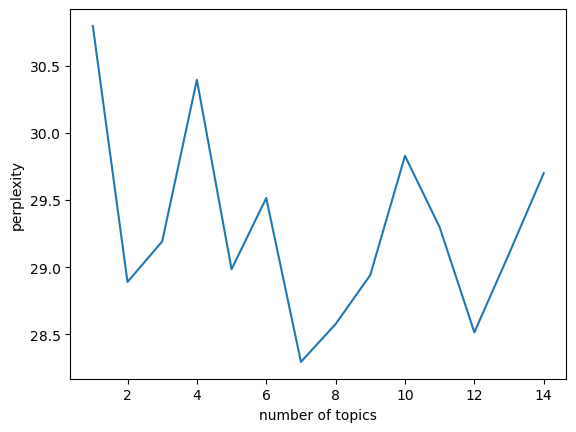

In [47]:
n_t=14#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()